## STEP 0. Ask Question

how to predict tomorrow's stock market performance, given historical treasury yield curve and volatility data?

## STEP 1. Data Acquisition

there are 3 types of data in this model: treasury yield curve, vix, and S&P index. 1st data is treasury daily yield curve rates from 2010 to 2018

In [1]:
import xmltodict
import pandas as pd
from collections import OrderedDict
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [16]:
sp_history = pd.read_csv('./data/SP.csv',header=0,names=['date','open','high','low','close','adj','vol'])

In [17]:
sp_history.head()

date         open         high          low        close  \
0  1999-02-04  1272.069946  1272.229980  1248.359985  1248.489990   
1  1999-02-05  1248.489990  1251.859985  1232.280029  1239.400024   
2  1999-02-08  1239.400024  1246.930054  1231.979980  1243.770020   
3  1999-02-09  1243.770020  1243.969971  1215.630005  1216.140015   
4  1999-02-10  1216.140015  1226.780029  1211.890015  1223.550049   

           adj        vol  
0  1248.489990  854400000  
1  1239.400024  872000000  
2  1243.770020  705400000  
3  1216.140015  736000000  
4  1223.550049  721400000

In [19]:
sp_history['date'] = pd.to_datetime(sp_history['date'])

In [20]:
sp_history = sp_history.set_index('date')

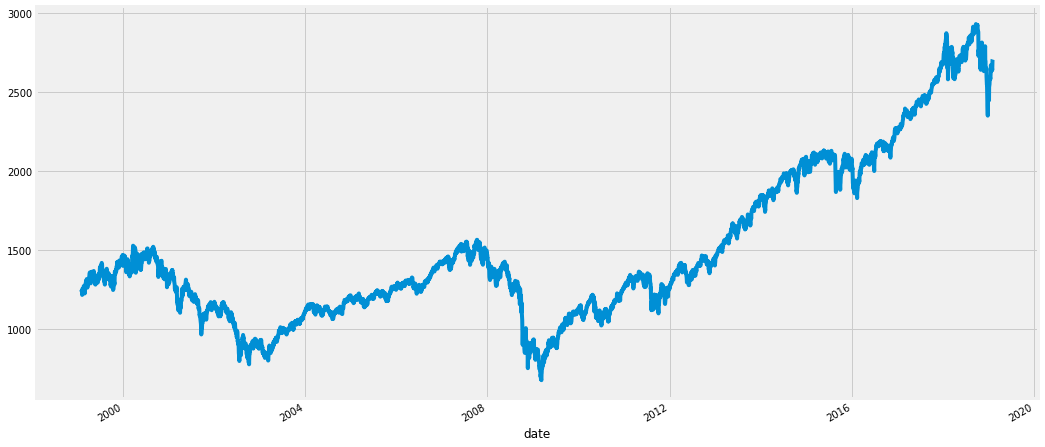

In [23]:
sp_history['close'].plot(figsize = (16,8))

the daily yield curve rate data from US treasury is in xml format and accesible by year. from 2010 to 2019, there is 9 years worth of data, three times the 'function worthy thresthold' proposed by [Datacamp's chief data scientist david robinson](http://varianceexplained.org/r/start-blog/). So i'm writing a function to turn treasury data xml into dataframe.

In [572]:
def treasury_data(year):
    url = 'https://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData?$filter=year(NEW_DATE)%20eq%20'+str(year)
    r = requests. get(url)
    jsdata = xmltodict.parse(r.content)
    jsdata = xmltodict.parse(r.content)
    length = len(jsdata['feed']['entry'])

    data_dict = {}

    for x in range(0,length):
        rates = []
        
        date = jsdata['feed']['entry'][x]['content']['m:properties']['d:NEW_DATE']['#text']            
        one_mon = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_1MONTH']['#text']
        three_mon = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_3MONTH']['#text']
        six_mon = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_6MONTH']['#text']
        ten_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_10YEAR']['#text']
        twenty_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_20YEAR']['#text']
        thirty_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_30YEAR']['#text']
        rates.append(date)
        rates.append(one_mon)
        rates.append(three_mon)
        rates.append(six_mon)
        rates.append(ten_yr)
        rates.append(twenty_yr)
        rates.append(thirty_yr)
        data_dict[x] = rates

    data_year = pd.DataFrame.from_dict(data_dict,orient='index',columns=['date','one_mon','three_mon','six_mon',
                                                                         'ten_yr','twenty_yr','thirty_yr'])
    return data_year

In [573]:
treasury_data(2018).head()

date one_mon three_mon six_mon ten_yr twenty_yr thirty_yr
0  2018-01-02T00:00:00    1.29      1.44    1.61   2.46      2.64      2.81
1  2018-01-03T00:00:00    1.29      1.41    1.59   2.44      2.62      2.78
2  2018-01-04T00:00:00    1.28      1.41     1.6   2.46      2.62      2.79
3  2018-01-05T00:00:00    1.27      1.39    1.58   2.47      2.64      2.81
4  2018-01-08T00:00:00     1.3      1.45     1.6   2.49      2.65      2.81

In [574]:
data_2018 = treasury_data(2018)
data_2017 = treasury_data(2017)
data_2016 = treasury_data(2016)
data_2015 = treasury_data(2015)
data_2014 = treasury_data(2014)
data_2013 = treasury_data(2013)
data_2012 = treasury_data(2012)
data_2011 = treasury_data(2011)

compiling 9 years treasury yield curve data

In [575]:
treasury = pd.concat([data_2018,data_2017,data_2016,data_2015,
                      data_2014,data_2013,data_2012,data_2011])

In [576]:
treasury.dtypes

date         object
one_mon      object
three_mon    object
six_mon      object
ten_yr       object
twenty_yr    object
thirty_yr    object
dtype: object

we will use rate differences as yield curve slope later in the process. so we need to convert feature data types from object to float.

In [577]:
treasury = treasury.convert_objects(convert_numeric=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [578]:
treasury.isnull().sum()

date         0
one_mon      0
three_mon    0
six_mon      0
ten_yr       0
twenty_yr    0
thirty_yr    0
dtype: int64

setting index to prepare for future data merge.

In [579]:
treasury['market_day'] = pd.to_datetime(treasury.date)
treasury = treasury.set_index('market_day')
treasury = treasury.drop('date',axis=1)

getting treasury yield curve slopes!

In [580]:
treasury['10yr1mon'] = treasury.ten_yr - treasury.one_mon
treasury['10yr3mon'] = treasury.ten_yr - treasury.three_mon
treasury['10yr6mon'] = treasury.ten_yr - treasury.six_mon
treasury['20yr1mon'] = treasury.twenty_yr - treasury.one_mon
treasury['20yr3mon'] = treasury.twenty_yr - treasury.three_mon
treasury['20yr6mon'] = treasury.twenty_yr - treasury.six_mon
treasury['30yr1mon'] = treasury.thirty_yr - treasury.one_mon
treasury['30yr3mon'] = treasury.thirty_yr - treasury.three_mon
treasury['30yr6mon'] = treasury.thirty_yr - treasury.six_mon

In [581]:
treasury.head()

one_mon  three_mon  six_mon  ten_yr  twenty_yr  thirty_yr  \
market_day                                                              
2018-01-02     1.29       1.44     1.61    2.46       2.64       2.81   
2018-01-03     1.29       1.41     1.59    2.44       2.62       2.78   
2018-01-04     1.28       1.41     1.60    2.46       2.62       2.79   
2018-01-05     1.27       1.39     1.58    2.47       2.64       2.81   
2018-01-08     1.30       1.45     1.60    2.49       2.65       2.81   

            10yr1mon  10yr3mon  10yr6mon  20yr1mon  20yr3mon  20yr6mon  \
market_day                                                               
2018-01-02      1.17      1.02      0.85      1.35      1.20      1.03   
2018-01-03      1.15      1.03      0.85      1.33      1.21      1.03   
2018-01-04      1.18      1.05      0.86      1.34      1.21      1.02   
2018-01-05      1.20      1.08      0.89      1.37      1.25      1.06   
2018-01-08      1.19      1.04      0.89      1.35      1.20      1.05   

            30yr1mon  30yr3mon  30yr6mon  
market_day                                
2018-01-02      1.52      1.37      1.20  
2018-01-03      1.49      1.37      1.19  
2018-01-04      1.51      1.38      1.19  
2018-01-05      1.54      1.42      1.23  
2018-01-08      1.51      1.36      1.21

2nd data is S&P500 daily index

In [582]:
sp_cols = ['market_day','sp_open','sp_high','sp_low','sp_close','sp_adj_close','sp_volume']
sp = pd.read_csv('./data/SP500.csv', header=0, names=sp_cols)

a little data manipulation to prepare it for future merge

In [583]:
sp = sp.set_index('market_day')

sp['sp_previous'] = sp['sp_close'].shift(1)

sp['sp_change'] = sp['sp_close']-sp['sp_previous']

sp['sp'] = sp['sp_close'].shift(-1)

sp.head()

sp_open      sp_high       sp_low     sp_close  sp_adj_close  \
market_day                                                                     
2008-01-02  1467.969971  1471.770020  1442.069946  1447.160034   1447.160034   
2008-01-03  1447.550049  1456.800049  1443.729980  1447.160034   1447.160034   
2008-01-04  1444.010010  1444.010010  1411.189941  1411.630005   1411.630005   
2008-01-07  1414.069946  1423.869995  1403.449951  1416.180054   1416.180054   
2008-01-08  1415.709961  1430.280029  1388.300049  1390.189941   1390.189941   

             sp_volume  sp_previous  sp_change           sp  
market_day                                                   
2008-01-02  3452650000          NaN        NaN  1447.160034  
2008-01-03  3429500000  1447.160034   0.000000  1411.630005  
2008-01-04  4166000000  1447.160034 -35.530029  1416.180054  
2008-01-07  4221260000  1411.630005   4.550049  1390.189941  
2008-01-08  4705390000  1416.180054 -25.990113  1409.130005

3rd data is the CBOE Volatility Index, VIX

In [584]:
vix_cols = ['day','vix_open','vix_high','vix_low','vix_close']
vix = pd.read_csv('./data/vix.csv', header=1, names=vix_cols)

vix['market_day'] = pd.to_datetime(vix.day)

vix = vix.set_index('market_day')
vix.head()

day  vix_open  vix_high  vix_low  vix_close
market_day                                                  
2004-01-02  1/2/2004     17.96     18.68    17.54      18.22
2004-01-05  1/5/2004     18.45     18.49    17.44      17.49
2004-01-06  1/6/2004     17.66     17.67    16.19      16.73
2004-01-07  1/7/2004     16.72     16.75    15.50      15.50
2004-01-08  1/8/2004     15.42     15.68    15.32      15.61

## STEP 2. Data Engineering

time to create the mega-dataset!

In [585]:
mega = pd.merge(treasury,sp,left_index=True, right_index=True)

In [586]:
mega.head()

one_mon  three_mon  six_mon  ten_yr  twenty_yr  thirty_yr  \
market_day                                                              
2018-01-02     1.29       1.44     1.61    2.46       2.64       2.81   
2018-01-03     1.29       1.41     1.59    2.44       2.62       2.78   
2018-01-04     1.28       1.41     1.60    2.46       2.62       2.79   
2018-01-05     1.27       1.39     1.58    2.47       2.64       2.81   
2018-01-08     1.30       1.45     1.60    2.49       2.65       2.81   

            10yr1mon  10yr3mon  10yr6mon  20yr1mon     ...       30yr6mon  \
market_day                                             ...                  
2018-01-02      1.17      1.02      0.85      1.35     ...           1.20   
2018-01-03      1.15      1.03      0.85      1.33     ...           1.19   
2018-01-04      1.18      1.05      0.86      1.34     ...           1.19   
2018-01-05      1.20      1.08      0.89      1.37     ...           1.23   
2018-01-08      1.19      1.04      0.89      1.35     ...           1.21   

                sp_open      sp_high       sp_low     sp_close  sp_adj_close  \
market_day                                                                     
2018-01-02  2683.729980  2695.889893  2682.360107  2695.810059   2695.810059   
2018-01-03  2697.850098  2714.370117  2697.770020  2713.060059   2713.060059   
2018-01-04  2719.310059  2729.290039  2719.070068  2723.989990   2723.989990   
2018-01-05  2731.330078  2743.449951  2727.919922  2743.149902   2743.149902   
2018-01-08  2742.669922  2748.510010  2737.600098  2747.709961   2747.709961   

             sp_volume  sp_previous  sp_change           sp  
market_day                                                   
2018-01-02  3367250000  2673.610107  22.199952  2713.060059  
2018-01-03  3538660000  2695.810059  17.250000  2723.989990  
2018-01-04  3695260000  2713.060059  10.929931  2743.149902  
2018-01-05  3236620000  2723.989990  19.159912  2747.709961  
2018-01-08  3242650000  2743.149902   4.560059  2751.290039  

[5 rows x 24 columns]

In [587]:
mega = pd.merge(mega,vix,left_index=True, right_index=True)

In [588]:
mega.tail()

one_mon  three_mon  six_mon  ten_yr  twenty_yr  thirty_yr  \
market_day                                                              
2011-12-23     0.00       0.01     0.04    2.03       2.73       3.05   
2011-12-27     0.01       0.02     0.06    2.02       2.72       3.04   
2011-12-28     0.00       0.01     0.05    1.93       2.59       2.91   
2011-12-29     0.00       0.02     0.07    1.91       2.58       2.90   
2011-12-30     0.01       0.02     0.06    1.89       2.57       2.89   

            10yr1mon  10yr3mon  10yr6mon  20yr1mon    ...      sp_adj_close  \
market_day                                            ...                     
2011-12-23      2.03      2.02      1.99      2.73    ...       1265.329956   
2011-12-27      2.01      2.00      1.96      2.71    ...       1265.430054   
2011-12-28      1.93      1.92      1.88      2.59    ...       1249.640015   
2011-12-29      1.91      1.89      1.84      2.58    ...       1263.020020   
2011-12-30      1.88      1.87      1.83      2.56    ...       1257.599976   

             sp_volume  sp_previous  sp_change           sp         day  \
market_day                                                                
2011-12-23  2233830000  1254.000000  11.329956  1265.430054  12/23/2011   
2011-12-27  2130590000  1265.329956   0.100098  1249.640015  12/27/2011   
2011-12-28  2349980000  1265.430054 -15.790039  1263.020020  12/28/2011   
2011-12-29  2278130000  1249.640015  13.380005  1257.599976  12/29/2011   
2011-12-30  2271850000  1263.020020  -5.420044  1277.060059  12/30/2011   

            vix_open  vix_high  vix_low  vix_close  
market_day                                          
2011-12-23     21.10     21.21    20.72      20.73  
2011-12-27     22.58     22.66    21.68      21.91  
2011-12-28     22.12     23.56    22.11      23.52  
2011-12-29     23.52     23.52    22.65      22.65  
2011-12-30     22.86     23.46    22.65      23.40  

[5 rows x 29 columns]

In [589]:
mega.shape

(1997, 29)

getting the subset of data for modeling.

In [590]:
data = mega[['10yr1mon', '10yr3mon', '10yr6mon', '20yr1mon', 
                '20yr3mon', '20yr6mon','30yr1mon', '30yr3mon', '30yr6mon',
                'vix_close', 'sp']]

In [591]:
data.head()

10yr1mon  10yr3mon  10yr6mon  20yr1mon  20yr3mon  20yr6mon  \
market_day                                                               
2018-01-02      1.17      1.02      0.85      1.35      1.20      1.03   
2018-01-03      1.15      1.03      0.85      1.33      1.21      1.03   
2018-01-04      1.18      1.05      0.86      1.34      1.21      1.02   
2018-01-05      1.20      1.08      0.89      1.37      1.25      1.06   
2018-01-08      1.19      1.04      0.89      1.35      1.20      1.05   

            30yr1mon  30yr3mon  30yr6mon  vix_close           sp  
market_day                                                        
2018-01-02      1.52      1.37      1.20       9.77  2713.060059  
2018-01-03      1.49      1.37      1.19       9.15  2723.989990  
2018-01-04      1.51      1.38      1.19       9.22  2743.149902  
2018-01-05      1.54      1.42      1.23       9.22  2747.709961  
2018-01-08      1.51      1.36      1.21       9.52  2751.290039

## STEP 3. EDA

In [592]:
data.dtypes

10yr1mon     float64
10yr3mon     float64
10yr6mon     float64
20yr1mon     float64
20yr3mon     float64
20yr6mon     float64
30yr1mon     float64
30yr3mon     float64
30yr6mon     float64
vix_close    float64
sp           float64
dtype: object

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1997 entries, 2018-01-02 to 2011-12-30
Data columns (total 11 columns):
10yr1mon     1997 non-null float64
10yr3mon     1997 non-null float64
10yr6mon     1997 non-null float64
20yr1mon     1997 non-null float64
20yr3mon     1997 non-null float64
20yr6mon     1997 non-null float64
30yr1mon     1997 non-null float64
30yr3mon     1997 non-null float64
30yr6mon     1997 non-null float64
vix_close    1997 non-null float64
sp           1997 non-null float64
dtypes: float64(11)
memory usage: 187.2 KB


In [24]:
data.describe()                    

10yr1mon     10yr3mon     10yr6mon     20yr1mon     20yr3mon  \
count  1997.000000  1997.000000  1997.000000  1997.000000  1997.000000   
mean      1.940946     1.896765     1.808808     2.452829     2.408648   
std       0.624727     0.656350     0.694817     0.811491     0.846475   
min       0.250000     0.240000     0.130000     0.430000     0.420000   
25%       1.480000     1.410000     1.280000     1.900000     1.820000   
50%       1.930000     1.890000     1.810000     2.460000     2.440000   
75%       2.330000     2.340000     2.290000     2.940000     2.930000   
max       3.620000     3.600000     3.570000     4.470000     4.430000   

          20yr6mon     30yr1mon     30yr3mon     30yr6mon    vix_close  \
count  1997.000000  1997.000000  1997.000000  1997.000000  1997.000000   
mean      2.320691     2.736755     2.692574     2.604617    16.319499   
std       0.889680     0.849184     0.885795     0.929345     5.536105   
min       0.310000     0.580000     0.550000     0.460000     9.140000   
25%       1.680000     2.240000     2.150000     2.000000    12.810000   
50%       2.370000     2.820000     2.800000     2.700000    14.840000   
75%       2.900000     3.240000     3.230000     3.190000    18.140000   
max       4.390000     4.670000     4.630000     4.590000    48.000000   

                sp  
count  1997.000000  
mean   1947.208883  
std     481.675760  
min    1099.229980  
25%    1461.890015  
50%    1986.510010  
75%    2267.889893  
max    2930.750000

plot the industry benchmart data: 10 year 3 month slope on the yield curve

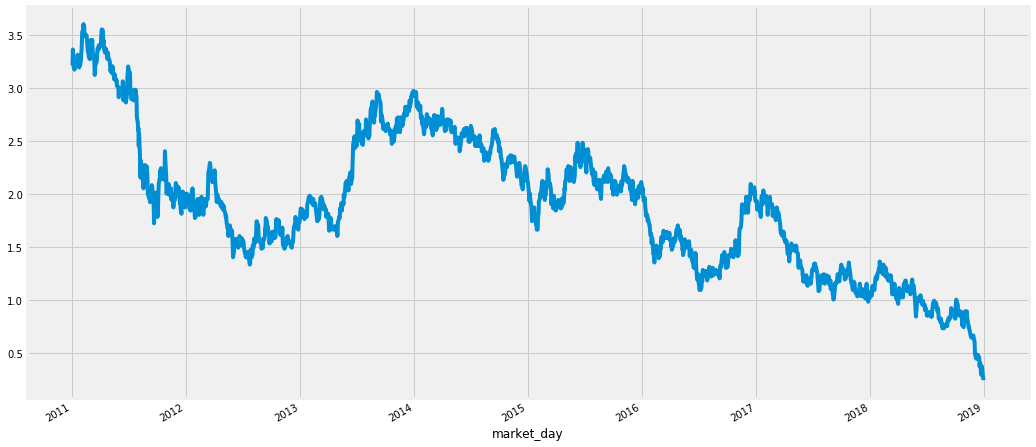

In [25]:
data['10yr3mon'].plot(figsize=(16,8))

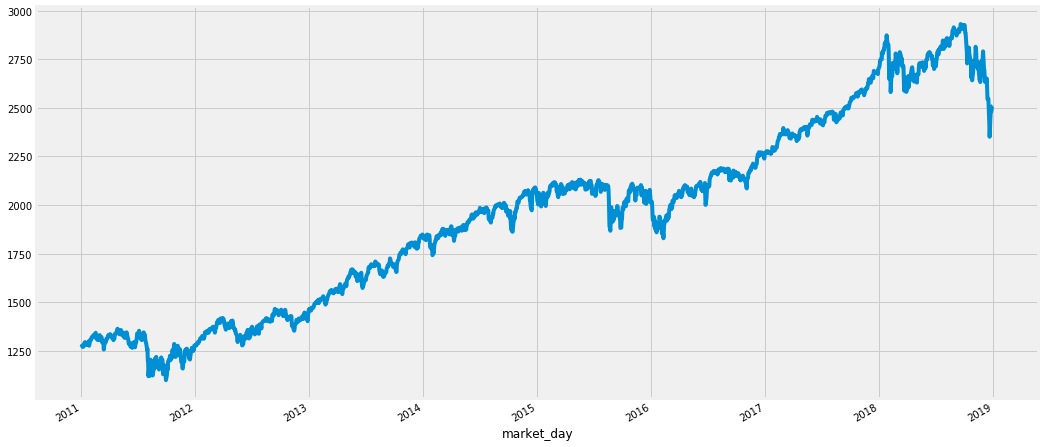

In [26]:
data['sp'].plot(figsize=(16,8))

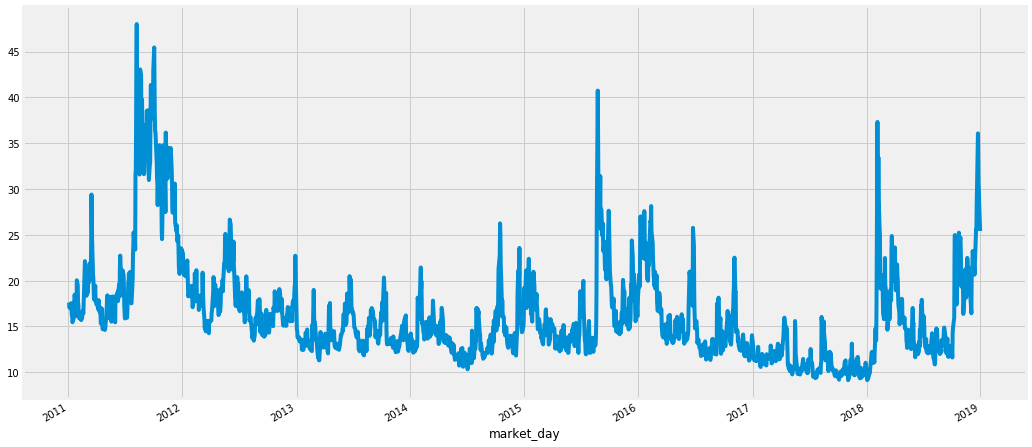

In [27]:
data['vix_close'].plot(figsize=(16,8))

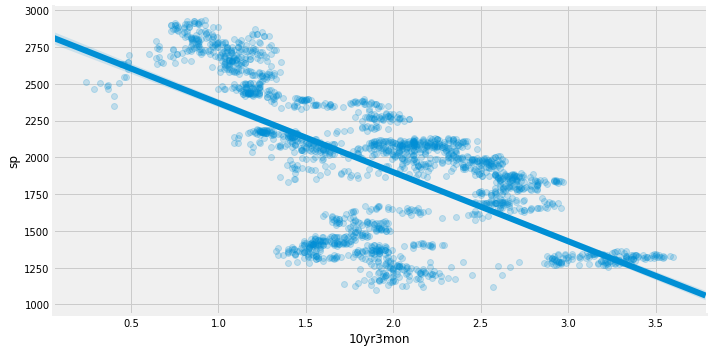

In [28]:
sns.lmplot(x='10yr3mon', y='sp', data=data, aspect=2, 
           scatter_kws={'alpha':0.2} );

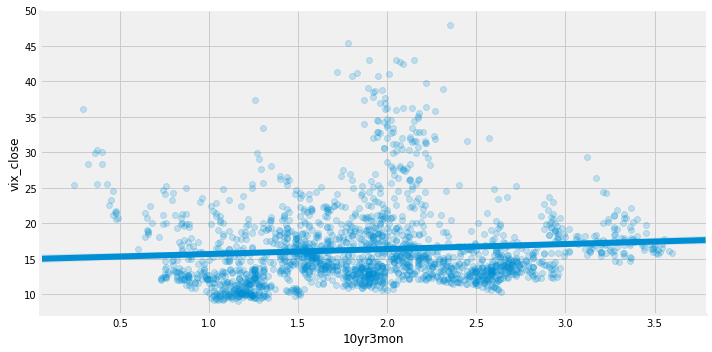

In [29]:
sns.lmplot(x='10yr3mon', y='vix_close', data=data, 
           aspect=2, scatter_kws={'alpha':0.2} );

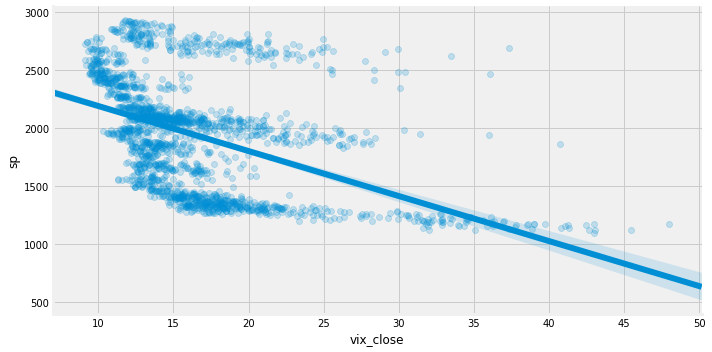

In [30]:
sns.lmplot(x='vix_close', y='sp', data=data, 
           aspect=2, scatter_kws={'alpha':0.2} );

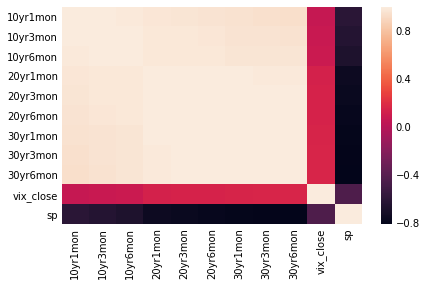

In [31]:
sns.heatmap(data.corr())

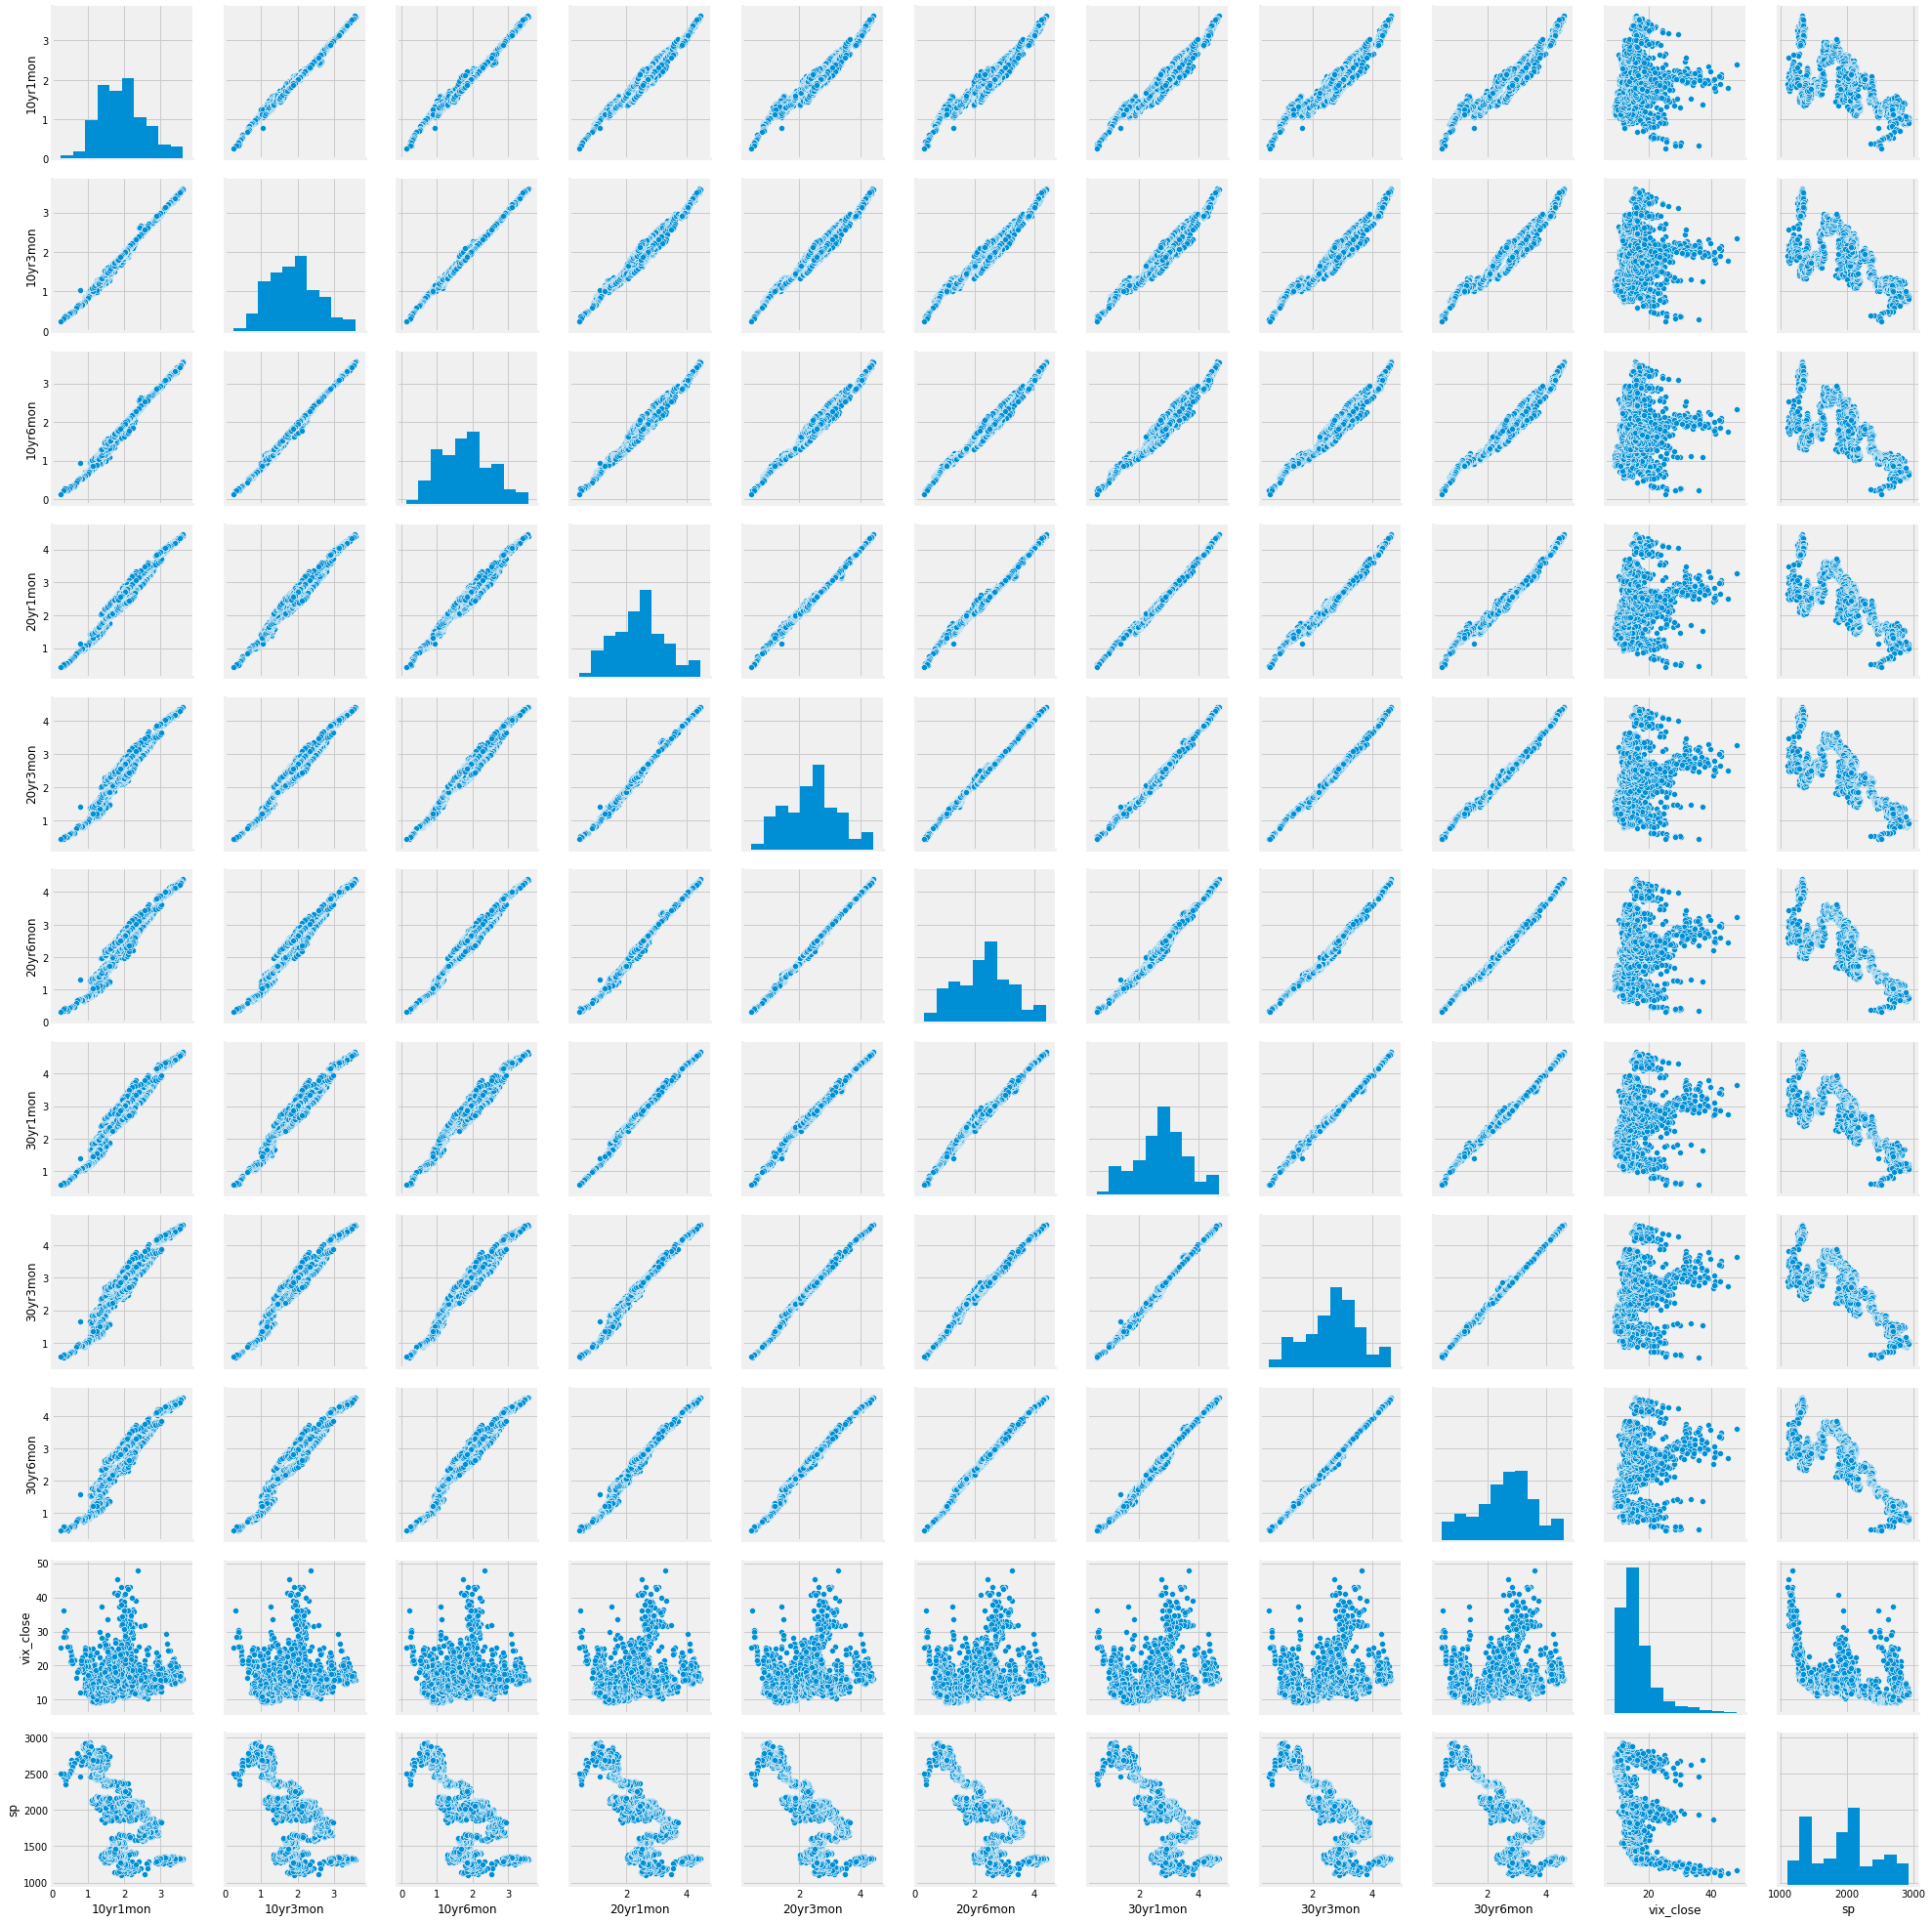

In [67]:
sns.pairplot(data)

# STEP 4. Data Engineering 2.0

considering there is a lot of sudden jumps in daily data, I will roll the dataset on a 7-day and 30-day basis to smooth it out

In [593]:
data.head()

10yr1mon  10yr3mon  10yr6mon  20yr1mon  20yr3mon  20yr6mon  \
market_day                                                               
2018-01-02      1.17      1.02      0.85      1.35      1.20      1.03   
2018-01-03      1.15      1.03      0.85      1.33      1.21      1.03   
2018-01-04      1.18      1.05      0.86      1.34      1.21      1.02   
2018-01-05      1.20      1.08      0.89      1.37      1.25      1.06   
2018-01-08      1.19      1.04      0.89      1.35      1.20      1.05   

            30yr1mon  30yr3mon  30yr6mon  vix_close           sp  
market_day                                                        
2018-01-02      1.52      1.37      1.20       9.77  2713.060059  
2018-01-03      1.49      1.37      1.19       9.15  2723.989990  
2018-01-04      1.51      1.38      1.19       9.22  2743.149902  
2018-01-05      1.54      1.42      1.23       9.22  2747.709961  
2018-01-08      1.51      1.36      1.21       9.52  2751.290039

the problem with current dataset is that it doesn't include data when the market is closed. this will cause problem when i later engineer the dataset to smooth it out and result into sudden jumps. to resolve the problem, i need to fill in the gaps by padding data to days when the market is closed.

In [594]:
data = data.resample('D').pad()

In [595]:
data['2018'].head(20)

10yr1mon  10yr3mon  10yr6mon  20yr1mon  20yr3mon  20yr6mon  \
market_day                                                               
2018-01-01      1.12      1.01      0.87      1.30      1.19      1.05   
2018-01-02      1.17      1.02      0.85      1.35      1.20      1.03   
2018-01-03      1.15      1.03      0.85      1.33      1.21      1.03   
2018-01-04      1.18      1.05      0.86      1.34      1.21      1.02   
2018-01-05      1.20      1.08      0.89      1.37      1.25      1.06   
2018-01-06      1.20      1.08      0.89      1.37      1.25      1.06   
2018-01-07      1.20      1.08      0.89      1.37      1.25      1.06   
2018-01-08      1.19      1.04      0.89      1.35      1.20      1.05   
2018-01-09      1.28      1.11      0.95      1.45      1.28      1.12   
2018-01-10      1.24      1.13      0.96      1.42      1.31      1.14   
2018-01-11      1.22      1.11      0.96      1.40      1.29      1.14   
2018-01-12      1.24      1.12      0.96      1.40      1.28      1.12   
2018-01-13      1.24      1.12      0.96      1.40      1.28      1.12   
2018-01-14      1.24      1.12      0.96      1.40      1.28      1.12   
2018-01-15      1.24      1.12      0.96      1.40      1.28      1.12   
2018-01-16      1.21      1.09      0.91      1.36      1.24      1.06   
2018-01-17      1.26      1.13      0.94      1.40      1.27      1.08   
2018-01-18      1.33      1.17      0.99      1.48      1.32      1.14   
2018-01-19      1.36      1.20      1.02      1.50      1.34      1.16   
2018-01-20      1.36      1.20      1.02      1.50      1.34      1.16   

            30yr1mon  30yr3mon  30yr6mon  vix_close           sp  
market_day                                                        
2018-01-01      1.46      1.35      1.21      11.04  2695.810059  
2018-01-02      1.52      1.37      1.20       9.77  2713.060059  
2018-01-03      1.49      1.37      1.19       9.15  2723.989990  
2018-01-04      1.51      1.38      1.19       9.22  2743.149902  
2018-01-05      1.54      1.42      1.23       9.22  2747.709961  
2018-01-06      1.54      1.42      1.23       9.22  2747.709961  
2018-01-07      1.54      1.42      1.23       9.22  2747.709961  
2018-01-08      1.51      1.36      1.21       9.52  2751.290039  
2018-01-09      1.61      1.44      1.28      10.08  2748.229980  
2018-01-10      1.57      1.46      1.29       9.82  2767.560059  
2018-01-11      1.59      1.48      1.33       9.88  2786.239990  
2018-01-12      1.54      1.42      1.26      10.16  2776.419922  
2018-01-13      1.54      1.42      1.26      10.16  2776.419922  
2018-01-14      1.54      1.42      1.26      10.16  2776.419922  
2018-01-15      1.54      1.42      1.26      10.16  2776.419922  
2018-01-16      1.50      1.38      1.20      11.66  2802.560059  
2018-01-17      1.53      1.40      1.21      11.91  2798.030029  
2018-01-18      1.61      1.45      1.27      12.22  2810.300049  
2018-01-19      1.63      1.47      1.29      11.27  2832.969971  
2018-01-20      1.63      1.47      1.29      11.27  2832.969971

as we can see from the dataset above, weekends, holidays have been filled with data from the previous market-open day.

In [596]:
data_7day = data.rolling(7, center=False).mean().dropna()

In [597]:
data_30day = data.rolling(30, center=False).mean().dropna()

In [598]:
data_7day.head(10)

10yr1mon  10yr3mon  10yr6mon  20yr1mon  20yr3mon  20yr6mon  \
market_day                                                               
2011-01-09  3.257143  3.240000  3.198571  4.130000  4.112857  4.071429   
2011-01-10  3.247143  3.234286  3.194286  4.132857  4.120000  4.080000   
2011-01-11  3.244286  3.234286  3.195714  4.135714  4.125714  4.087143   
2011-01-12  3.227143  3.218571  3.182857  4.124286  4.115714  4.080000   
2011-01-13  3.210000  3.204286  3.168571  4.111429  4.105714  4.070000   
2011-01-14  3.210000  3.204286  3.170000  4.112857  4.107143  4.072857   
2011-01-15  3.210000  3.204286  3.171429  4.114286  4.108571  4.075714   
2011-01-16  3.210000  3.204286  3.172857  4.115714  4.110000  4.078571   
2011-01-17  3.214286  3.208571  3.177143  4.121429  4.115714  4.084286   
2011-01-18  3.217143  3.210000  3.180000  4.128571  4.121429  4.091429   

            30yr1mon  30yr3mon  30yr6mon  vix_close           sp  
market_day                                                        
2011-01-09  4.352857  4.335714  4.294286  17.261429  1271.622855  
2011-01-10  4.360000  4.347143  4.307143  17.251429  1272.234288  
2011-01-11  4.362857  4.352857  4.314286  17.181429  1273.577131  
2011-01-12  4.355714  4.347143  4.311429  17.070000  1274.992850  
2011-01-13  4.348571  4.342857  4.307143  16.925714  1278.098563  
2011-01-14  4.354286  4.348571  4.314286  16.685714  1281.708566  
2011-01-15  4.360000  4.354286  4.321429  16.445714  1285.318569  
2011-01-16  4.365714  4.360000  4.328571  16.205714  1288.928572  
2011-01-17  4.374286  4.368571  4.337143  15.908571  1291.862863  
2011-01-18  4.384286  4.377143  4.347143  15.762857  1291.285732

In [599]:
data_30day.head(10)

10yr1mon  10yr3mon  10yr6mon  20yr1mon  20yr3mon  20yr6mon  \
market_day                                                               
2011-02-01  3.249000  3.238333  3.210000  4.142000  4.131333  4.103000   
2011-02-02  3.253000  3.243333  3.215667  4.147667  4.138000  4.110333   
2011-02-03  3.259667  3.250667  3.223333  4.154333  4.145333  4.118000   
2011-02-04  3.265667  3.256333  3.229667  4.160000  4.150667  4.124000   
2011-02-05  3.273667  3.264333  3.237667  4.166667  4.157333  4.130667   
2011-02-06  3.285000  3.275333  3.249000  4.175333  4.165667  4.139333   
2011-02-07  3.296333  3.286000  3.260333  4.183667  4.173333  4.147667   
2011-02-08  3.309667  3.299333  3.274000  4.193667  4.183333  4.158000   
2011-02-09  3.321667  3.310667  3.285000  4.203333  4.192333  4.166667   
2011-02-10  3.335000  3.322667  3.297000  4.215333  4.203000  4.177333   

            30yr1mon  30yr3mon  30yr6mon  vix_close           sp  
market_day                                                        
2011-02-01  4.387000  4.376333  4.348000  17.387333  1285.686666  
2011-02-02  4.394000  4.384333  4.356667  17.377000  1286.916667  
2011-02-03  4.401000  4.392000  4.364667  17.354000  1288.060331  
2011-02-04  4.407000  4.397667  4.371000  17.317667  1289.567000  
2011-02-05  4.413667  4.404333  4.377667  17.268667  1291.152002  
2011-02-06  4.422000  4.412333  4.386000  17.228333  1292.795337  
2011-02-07  4.429667  4.419333  4.393667  17.199667  1294.622669  
2011-02-08  4.438667  4.428333  4.403000  17.155333  1296.327002  
2011-02-09  4.447667  4.436667  4.411000  17.099667  1297.906669  
2011-02-10  4.458667  4.446333  4.420667  17.073000  1299.346338

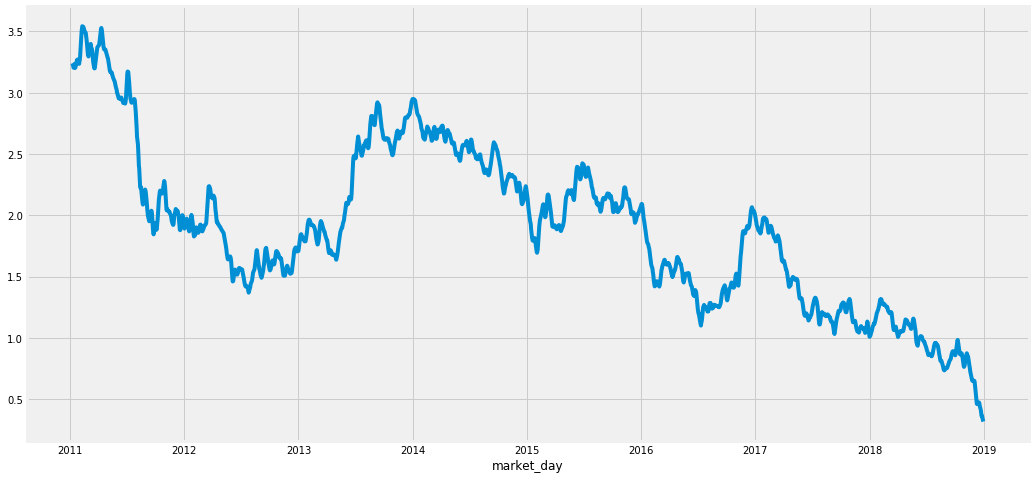

In [218]:
data_7day['10yr3mon'].plot(figsize=(16,8))

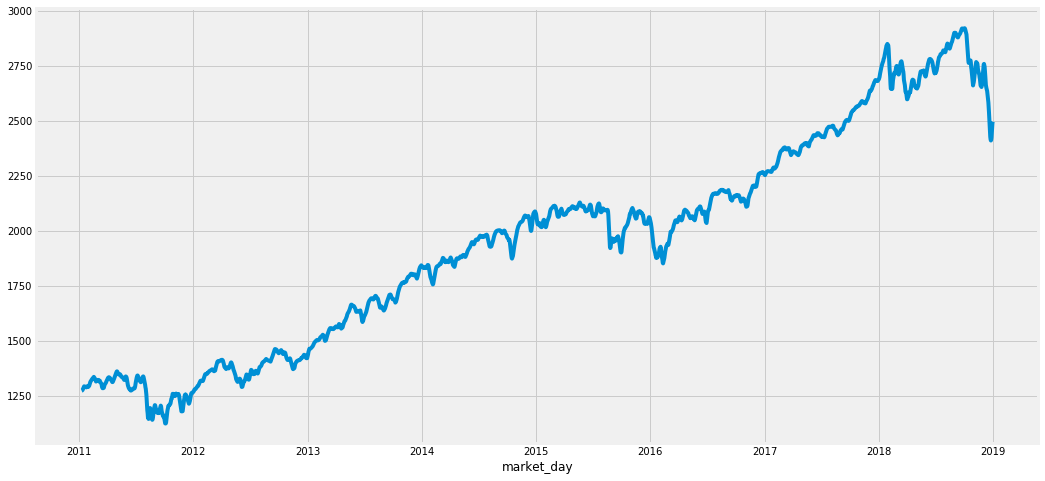

In [219]:
data_7day['sp'].plot(figsize=(16,8))

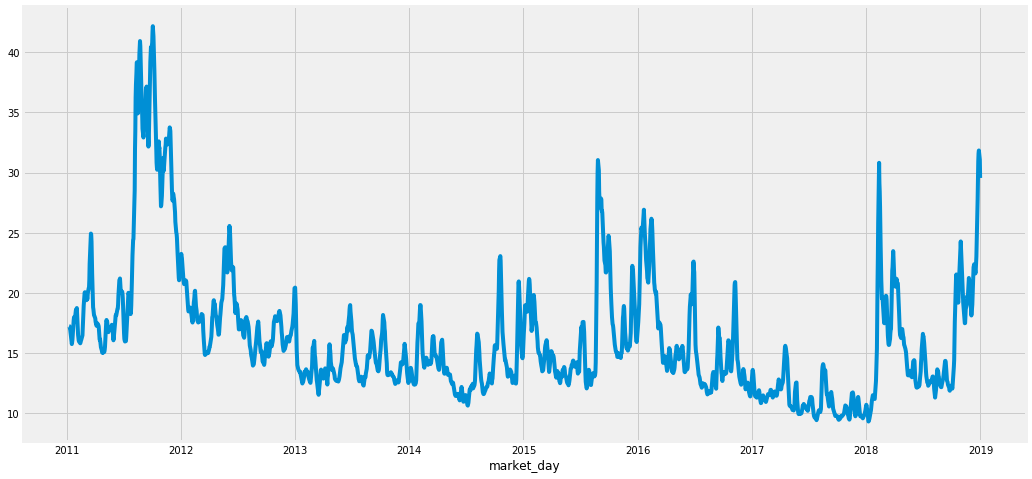

In [217]:
data_7day['vix_close'].plot(figsize=(16,8))

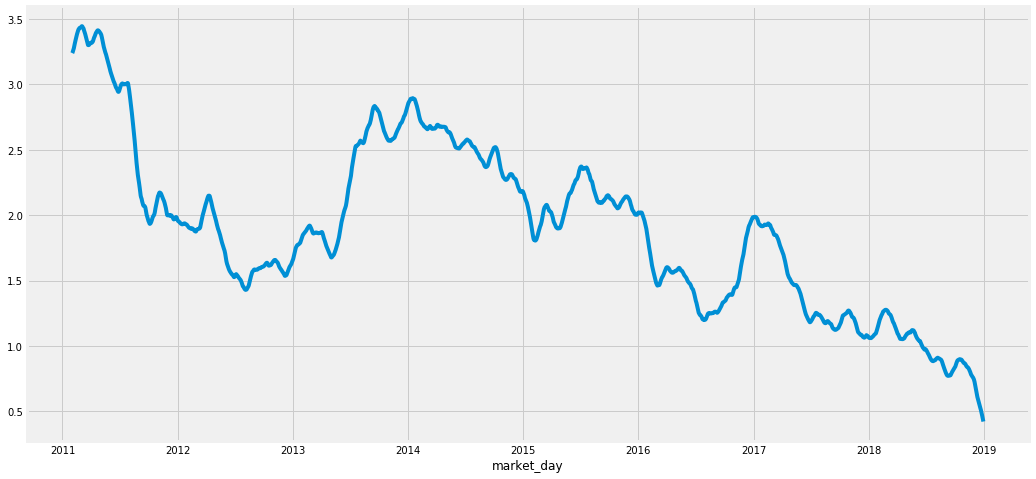

In [220]:
data_30day['10yr3mon'].plot(figsize=(16,8))

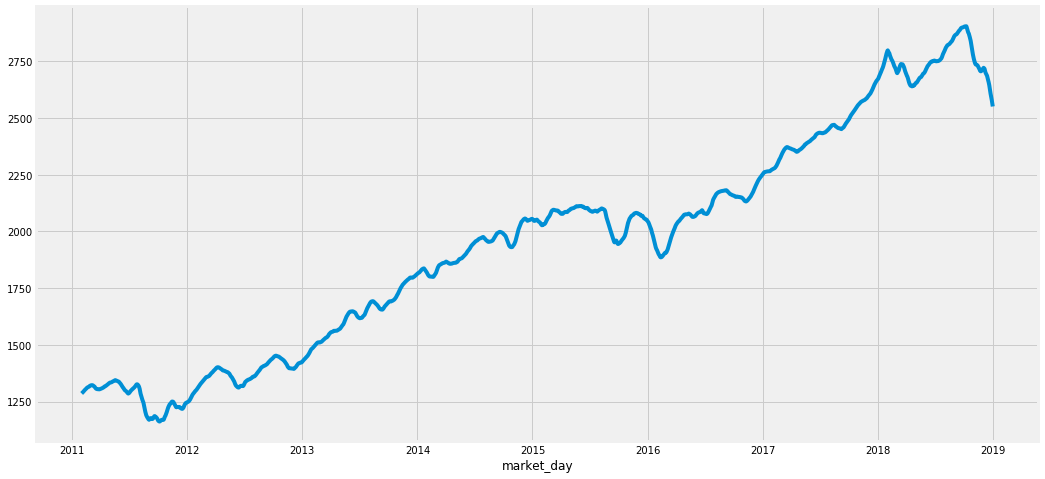

In [221]:
data_30day['sp'].plot(figsize=(16,8))

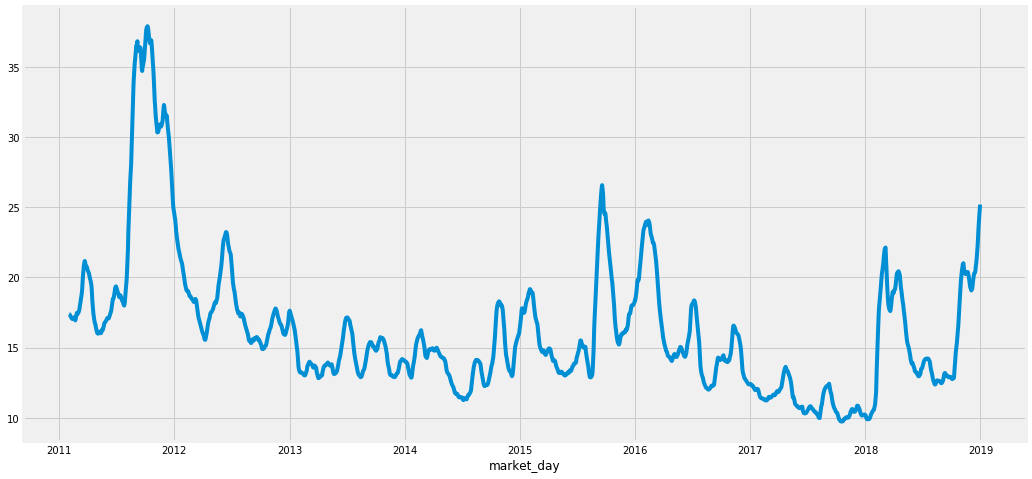

In [222]:
data_30day['vix_close'].plot(figsize=(16,8))

as shown above, 30 day data is indeed more smooth than 7 day data. 

## STEP 5. Model Selection

first up, see if the characteristics of the dataset satisfies assumptions for linear regression (including ridge)

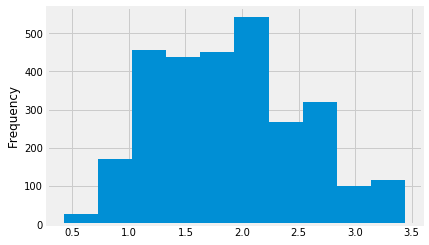

In [226]:
data_30day['10yr3mon'].plot(kind='hist')

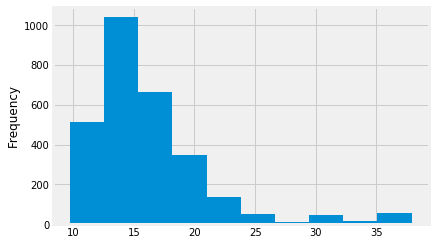

In [227]:
data_30day['vix_close'].plot(kind='hist')

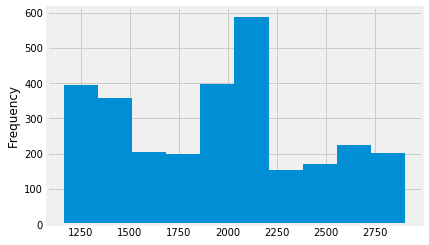

In [228]:
data_30day['sp'].plot(kind='hist')

conclusion: the dataset has following problems for linear regression:

1. it does not exhibit multivariate normality, meaning the data is not normally distributed

2. from domain knowledge, there is a lot of multicollinearity in the dataset.

also, I did run linear (and ridge) regression and the results are terrible... 


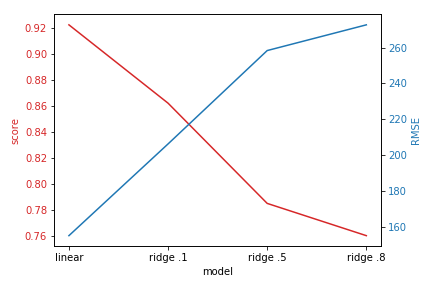

In [230]:
from IPython.display import Image
Image("./asset/foo.png")

the RMSE is extremely high for the y averaging 2500

so I have to choose a different model with less assumptions about input data

I've chosen random forest

## STEP 6. Model Fitting

In [600]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

**below is model fitting on daily data**

In [601]:
feature_cols = ['10yr1mon', '10yr3mon', '10yr6mon', '20yr1mon', 
                '20yr3mon', '20yr6mon','30yr1mon', '30yr3mon', '30yr6mon',
                'vix_close']

y = data['sp']
X = data[feature_cols]

In [602]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=111)

In [603]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
rfr_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rfr_score = rfr.score(X_test, y_test)

In [604]:
rfr_RMSE

50.64721596867262

In [605]:
rfr_score

0.988987531430223

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


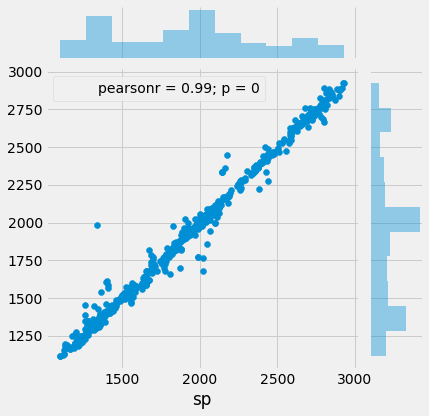

In [606]:
sns.jointplot(y_test,y_pred)

below is model fitting on 7-day data

In [607]:
Xw = data_7day[feature_cols]
yw = data_7day['sp']

In [608]:
Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw, yw,random_state=111)

rfrw = RandomForestRegressor()
rfrw.fit(Xw_train, yw_train)
yw_pred = rfrw.predict(Xw_test)
rfrw_RMSE = np.sqrt(metrics.mean_squared_error(yw_test, yw_pred))
rfrw_score = rfrw.score(Xw_test,yw_test)

In [609]:
rfrw_RMSE

41.339257126978154

In [610]:
rfrw.score(Xw_test,yw_test)

0.9926996682557263

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


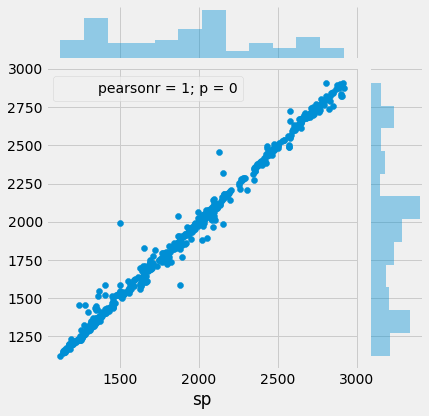

In [611]:
sns.jointplot(yw_test,yw_pred)

performance improves on 7-day data

below is model fitting on 30-day data

In [612]:
Xm = data_30day[feature_cols]
ym = data_30day['sp']

Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym,random_state=111)

rfrm = RandomForestRegressor()
rfrm.fit(Xm_train, ym_train)
ym_pred = rfrm.predict(Xm_test)
rfrm_RMSE = np.sqrt(metrics.mean_squared_error(ym_test, ym_pred))
rfrm_score = rfrm.score(Xm_test,ym_test)

In [613]:
rfrm_RMSE

41.050613735866364

In [614]:
rfrm.score(Xm_test,ym_test)

0.9928847085720144

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


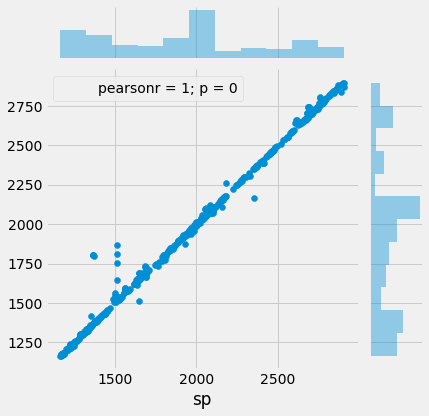

In [615]:
sns.jointplot(ym_test,ym_pred)

the 30-day dataset performs well

## STEP 7. Model Interpretation

visualizing a Single Decision Tree


In [247]:
from sklearn.tree import export_graphviz
import os

tree = rfrm.estimators_[5]

In [248]:
export_graphviz(tree,
                feature_names=X.columns,
                filled=True,
                rounded=True)

/anaconda3/lib/python3.6/site-packages/sklearn/tree/export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


In [249]:
os.system('dot -Tpng tree.dot -o tree.png')

0

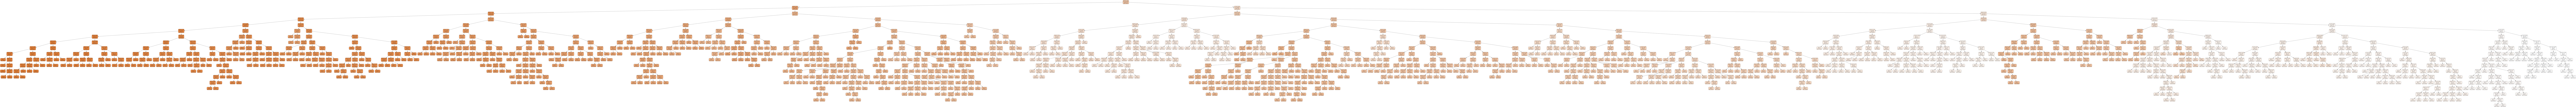

In [250]:
Image("./asset/tree.png")

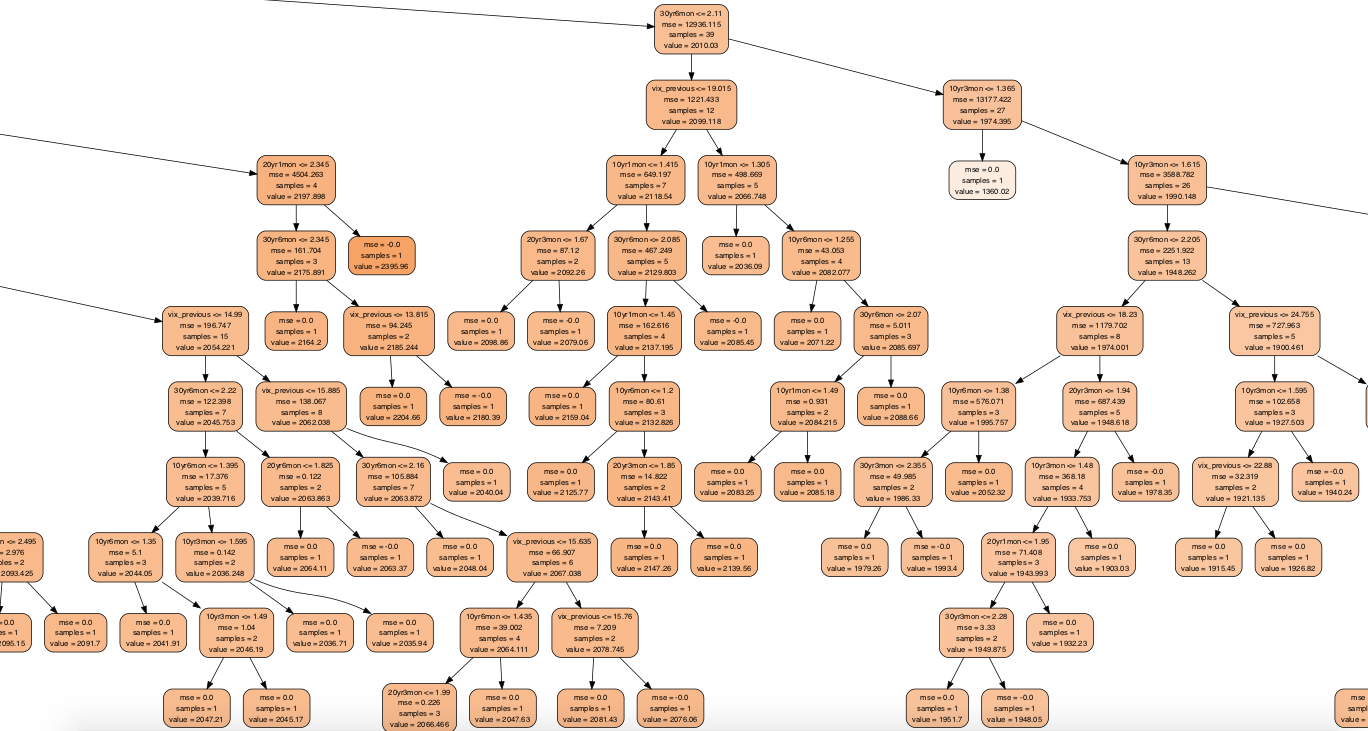

In [251]:
Image('./asset/tree_zoomin.png')

feature reduction

from the tree graph, it seems different variables have various contribution to the final prediction

In [252]:
importances = list(rfrm.feature_importances_)

feature_importances =pd.DataFrame([(feature, round(importance, 6)) 
                                   for feature, importance in zip(feature_cols, importances)],
                                  columns=['feature','importance']).set_index('feature')

feature_importances= feature_importances.sort_values('importance')

In [253]:
feature_importances

importance
feature              
20yr3mon     0.001841
20yr6mon     0.002306
20yr1mon     0.002432
30yr1mon     0.006136
10yr6mon     0.013165
10yr1mon     0.039956
10yr3mon     0.052699
30yr3mon     0.065700
vix_close    0.112693
30yr6mon     0.703072

from two dataframes above, we can see that the finance industry conventionally benchmark (10yr3mon) is actually not the most effective indicator of stock performance. Instead, 30yr6mon and previous day's volatility count of more than 80% in predicting tomorrow's stock performance. Below, I will refine the model by including *only* features that have tangible contribution to the model.

In [258]:
rfr_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

important_indices = list(feature_importances.index)[2:10]

In [260]:
index_list = list(feature_importances.feature)

In [261]:
important_indices = []

important_indices = [x for x in index_list 
                     if (feature_importances[feature_importances.feature == x].importance >= 0.025).bool()]

In [262]:
important_indices

['10yr1mon', '10yr3mon', '30yr3mon', '30yr6mon', 'vix_close']

In [263]:
feature_cols = important_indices

y = data_30day['sp']
X = data_30day[feature_cols]


X_train, X_test, y_train, y_test = train_test_split(X, y)

rfr_lean = RandomForestRegressor()
rfr_lean.fit(X_train, y_train)

y_pred = rfr_lean.predict(X_test)
rfr_lean_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rfr_lean_score = rfr_lean.score(X_test,y_test)


In [264]:
rfr_lean_RMSE

29.40384422585024

In [265]:
rfr_lean_score

0.9964110972380927

by excluding features of little contribution, we created a model with good predictivity without much sacrifice on accuracy.

compare our model with baseline, aka mean S&P index

In [266]:
y_null = np.zeros_like(y_test, dtype=float)
y_null.fill(y_test.mean())
y_null

array([1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551328,
       1959.54551328, 1959.54551328, 1959.54551328, 1959.54551

In [267]:
print ("benchmark_RMSE {}".format(np.sqrt(metrics.mean_squared_error(y_test, y_null))))                               
print("rfr_lean_RMSE {}".format(rfr_lean_RMSE))

benchmark_RMSE 490.82114864309233
rfr_lean_RMSE 29.40384422585024


**Conclusion: improvement of model performance 16.9 times against baseline**

## STEP 8. Model Improvement

1. Use more (high-quality) data and feature engineering

2. Tune the hyperparameters of the algorithm

3. Try different algorithms

in this project, due to constrains on time, i will only execuate on the first model improvement method: data

previously, I only included data from 2011 to 2018 and it was becasue in 2010 and 2008 data, null data points start to appear (due to extreme volatility in those days...) so first, I need to update the data acquisition model to handle such edge cases. secondly, i want to incorporate more rates differences.**



but there are several problems

treasury data structure is not always the same. before October 1st, 1993, there is not 20yr treasury data. 1-month data didn't start appearing until July 2001. 30-year Treasury constant maturity series was discontinued on February 18, 2002 and reintroduced on February 9, 2006.

furthermore, the world before October 3rd and the world after it, witness two idiosyncratic financial markets. On this day, Congress passed the Emergency Economic Stabilization Act. This bill became the vehicle for passage of economic stimulus relief during the 2008 financial crisis and gave treasury the authority of unconvential monetary policy. The treasury yields before and after this date, are from two worlds. We are still very much living in the financial market post 2008 and thus only data after that is relevant to our model.

why am I so sure about the significance of this Act? because I work for the architect of the Act

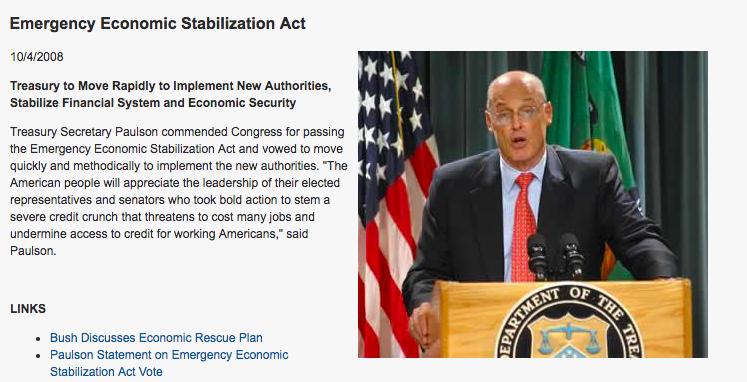

In [282]:
Image('./asset/act.png')

In [616]:
def treasury_data(year):
    url = 'https://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData?$filter=year(NEW_DATE)%20eq%20'+str(year)
    r = requests. get(url)
    jsdata = xmltodict.parse(r.content)
    jsdata = xmltodict.parse(r.content)
    length = len(jsdata['feed']['entry'])

    data_dict = {}

    for x in range(0,length):
        rates = []
        try:
            date = jsdata['feed']['entry'][x]['content']['m:properties']['d:NEW_DATE']['#text']            
            one_mon = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_1MONTH']['#text']
            three_mon = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_3MONTH']['#text']
            six_mon = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_6MONTH']['#text']
            one_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_1YEAR']['#text']
            two_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_2YEAR']['#text']
            three_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_3YEAR']['#text']
            five_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_5YEAR']['#text']
            seven_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_7YEAR']['#text']
            ten_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_10YEAR']['#text']
            twenty_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_20YEAR']['#text']
            thirty_yr = jsdata['feed']['entry'][x]['content']['m:properties']['d:BC_30YEAR']['#text']
            rates.append(date)
            rates.append(one_mon)
            rates.append(three_mon)
            rates.append(six_mon)
            rates.append(one_yr)
            rates.append(two_yr)
            rates.append(three_yr)
            rates.append(five_yr)
            rates.append(seven_yr)
            rates.append(ten_yr)
            rates.append(twenty_yr)
            rates.append(thirty_yr)
            data_dict[x] = rates
        except:
            print('hit a null')            
            
    data_year = pd.DataFrame.from_dict(data_dict,orient='index',
                                       columns=['date','one_mon','three_mon','six_mon','one_yr',
                                                'two_yr','three_yr','five_yr','seven_yr',
                                                'ten_yr','twenty_yr','thirty_yr'])
    return data_year

In [617]:
data_2018 = treasury_data(2018)
data_2017 = treasury_data(2017)
data_2016 = treasury_data(2016)
data_2015 = treasury_data(2015)
data_2014 = treasury_data(2014)
data_2013 = treasury_data(2013)
data_2012 = treasury_data(2012)
data_2011 = treasury_data(2011)
data_2010 = treasury_data(2010)
data_2009 = treasury_data(2009)
data_2008 = treasury_data(2008)

hit a null
hit a null
hit a null
hit a null


In [618]:
treasury = pd.concat([data_2018,data_2017,data_2016,data_2015,
                      data_2014,data_2013,data_2012,data_2011,
                      data_2010,data_2009,data_2008])

treasury = treasury.convert_objects(convert_numeric=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """


In [619]:
treasury.head()

date  one_mon  three_mon  six_mon  one_yr  two_yr  three_yr  \
0  2018-01-02T00:00:00     1.29       1.44     1.61    1.83    1.92      2.01   
1  2018-01-03T00:00:00     1.29       1.41     1.59    1.81    1.94      2.02   
2  2018-01-04T00:00:00     1.28       1.41     1.60    1.82    1.96      2.05   
3  2018-01-05T00:00:00     1.27       1.39     1.58    1.80    1.96      2.06   
4  2018-01-08T00:00:00     1.30       1.45     1.60    1.79    1.96      2.07   

   five_yr  seven_yr  ten_yr  twenty_yr  thirty_yr  
0     2.25      2.38    2.46       2.64       2.81  
1     2.25      2.37    2.44       2.62       2.78  
2     2.27      2.38    2.46       2.62       2.79  
3     2.29      2.40    2.47       2.64       2.81  
4     2.29      2.41    2.49       2.65       2.81

In [620]:
treasury['market_day'] = pd.to_datetime(treasury.date)
treasury = treasury.set_index('market_day')
treasury = treasury.drop('date',axis=1)

treasury['1yr1mon'] = treasury.one_yr - treasury.one_mon
treasury['1yr3mon'] = treasury.one_yr - treasury.three_mon
treasury['1yr6mon'] = treasury.one_yr - treasury.six_mon

treasury['2yr1mon'] = treasury.two_yr - treasury.one_mon
treasury['2yr3mon'] = treasury.two_yr - treasury.three_mon
treasury['2yr6mon'] = treasury.two_yr - treasury.six_mon


treasury['3yr1mon'] = treasury.three_yr - treasury.one_mon
treasury['3yr3mon'] = treasury.three_yr - treasury.three_mon
treasury['3yr6mon'] = treasury.three_yr - treasury.six_mon

treasury['5yr1mon'] = treasury.five_yr - treasury.one_mon
treasury['5yr3mon'] = treasury.five_yr - treasury.three_mon
treasury['5yr6mon'] = treasury.five_yr - treasury.six_mon

treasury['7yr1mon'] = treasury.seven_yr - treasury.one_mon
treasury['7yr3mon'] = treasury.seven_yr - treasury.three_mon
treasury['7yr6mon'] = treasury.seven_yr - treasury.six_mon

treasury['10yr1mon'] = treasury.ten_yr - treasury.one_mon
treasury['10yr3mon'] = treasury.ten_yr - treasury.three_mon
treasury['10yr6mon'] = treasury.ten_yr - treasury.six_mon


treasury['20yr1mon'] = treasury.twenty_yr - treasury.one_mon
treasury['20yr3mon'] = treasury.twenty_yr - treasury.three_mon
treasury['20yr6mon'] = treasury.twenty_yr - treasury.six_mon

treasury['30yr1mon'] = treasury.thirty_yr - treasury.one_mon
treasury['30yr3mon'] = treasury.thirty_yr - treasury.three_mon
treasury['30yr6mon'] = treasury.thirty_yr - treasury.six_mon

In [621]:
sp_cols = ['market_day','sp_open','sp_high','sp_low','sp_close','sp_adj_close','sp_volume']
sp = pd.read_csv('./data/SP2008.csv', header=0, names=sp_cols)

sp = sp.set_index('market_day')
sp['sp_previous'] = sp['sp_close'].shift(1)
sp['sp_change'] = sp['sp_close']-sp['sp_previous']
sp['sp'] = sp['sp_close'].shift(-1)

sp.head()

sp_open      sp_high       sp_low     sp_close  sp_adj_close  \
market_day                                                                     
2008-01-02  1467.969971  1471.770020  1442.069946  1447.160034   1447.160034   
2008-01-03  1447.550049  1456.800049  1443.729980  1447.160034   1447.160034   
2008-01-04  1444.010010  1444.010010  1411.189941  1411.630005   1411.630005   
2008-01-07  1414.069946  1423.869995  1403.449951  1416.180054   1416.180054   
2008-01-08  1415.709961  1430.280029  1388.300049  1390.189941   1390.189941   

             sp_volume  sp_previous  sp_change           sp  
market_day                                                   
2008-01-02  3452650000          NaN        NaN  1447.160034  
2008-01-03  3429500000  1447.160034   0.000000  1411.630005  
2008-01-04  4166000000  1447.160034 -35.530029  1416.180054  
2008-01-07  4221260000  1411.630005   4.550049  1390.189941  
2008-01-08  4705390000  1416.180054 -25.990113  1409.130005

In [622]:
vix_cols = ['market_day','vix_open','vix_high','vix_low','vix_close']
vix = pd.read_csv('./data/vix.csv', header=1, names=vix_cols)

vix = vix.set_index('market_day')

vix['vix_previous'] = vix['vix_close'].shift(1)

vix.head()

vix_open  vix_high  vix_low  vix_close  vix_previous
market_day                                                      
1/2/2004       17.96     18.68    17.54      18.22           NaN
1/5/2004       18.45     18.49    17.44      17.49         18.22
1/6/2004       17.66     17.67    16.19      16.73         17.49
1/7/2004       16.72     16.75    15.50      15.50         16.73
1/8/2004       15.42     15.68    15.32      15.61         15.50

In [623]:
mega = pd.merge(treasury,sp,left_index=True, right_index=True)
mega = pd.merge(mega,vix,left_index=True, right_index=True)

In [624]:
mega.head()

one_mon  three_mon  six_mon  one_yr  two_yr  three_yr  five_yr  \
market_day                                                                   
2018-01-02     1.29       1.44     1.61    1.83    1.92      2.01     2.25   
2018-01-03     1.29       1.41     1.59    1.81    1.94      2.02     2.25   
2018-01-04     1.28       1.41     1.60    1.82    1.96      2.05     2.27   
2018-01-05     1.27       1.39     1.58    1.80    1.96      2.06     2.29   
2018-01-08     1.30       1.45     1.60    1.79    1.96      2.07     2.29   

            seven_yr  ten_yr  twenty_yr      ...       sp_adj_close  \
market_day                                   ...                      
2018-01-02      2.38    2.46       2.64      ...        2695.810059   
2018-01-03      2.37    2.44       2.62      ...        2713.060059   
2018-01-04      2.38    2.46       2.62      ...        2723.989990   
2018-01-05      2.40    2.47       2.64      ...        2743.149902   
2018-01-08      2.41    2.49       2.65      ...        2747.709961   

             sp_volume  sp_previous  sp_change           sp  vix_open  \
market_day                                                              
2018-01-02  3367250000  2673.610107  22.199952  2713.060059     10.95   
2018-01-03  3538660000  2695.810059  17.250000  2723.989990      9.56   
2018-01-04  3695260000  2713.060059  10.929931  2743.149902      9.01   
2018-01-05  3236620000  2723.989990  19.159912  2747.709961      9.10   
2018-01-08  3242650000  2743.149902   4.560059  2751.290039      9.61   

            vix_high  vix_low  vix_close  vix_previous  
market_day                                              
2018-01-02     11.07     9.52       9.77         11.04  
2018-01-03      9.65     8.94       9.15          9.77  
2018-01-04      9.31     8.92       9.22          9.15  
2018-01-05      9.54     9.00       9.22          9.22  
2018-01-08      9.89     9.32       9.52          9.22  

[5 rows x 49 columns]

In [625]:
mega.columns

Index(['one_mon', 'three_mon', 'six_mon', 'one_yr', 'two_yr', 'three_yr',
       'five_yr', 'seven_yr', 'ten_yr', 'twenty_yr', 'thirty_yr', '1yr1mon',
       '1yr3mon', '1yr6mon', '2yr1mon', '2yr3mon', '2yr6mon', '3yr1mon',
       '3yr3mon', '3yr6mon', '5yr1mon', '5yr3mon', '5yr6mon', '7yr1mon',
       '7yr3mon', '7yr6mon', '10yr1mon', '10yr3mon', '10yr6mon', '20yr1mon',
       '20yr3mon', '20yr6mon', '30yr1mon', '30yr3mon', '30yr6mon', 'sp_open',
       'sp_high', 'sp_low', 'sp_close', 'sp_adj_close', 'sp_volume',
       'sp_previous', 'sp_change', 'sp', 'vix_open', 'vix_high', 'vix_low',
       'vix_close', 'vix_previous'],
      dtype='object')

In [626]:
data = mega[['1yr1mon','1yr3mon', '1yr6mon', '2yr1mon', '2yr3mon', '2yr6mon', 
            '3yr1mon','3yr3mon', '3yr6mon', '5yr1mon', '5yr3mon', '5yr6mon', 
            '7yr1mon','7yr3mon', '7yr6mon', '10yr1mon', '10yr3mon', '10yr6mon', 
            '20yr1mon','20yr3mon', '20yr6mon', '30yr1mon', '30yr3mon', '30yr6mon', 
            'sp','vix_close']]

In [627]:
data.head()

1yr1mon  1yr3mon  1yr6mon  2yr1mon  2yr3mon  2yr6mon  3yr1mon  \
market_day                                                                  
2018-01-02     0.54     0.39     0.22     0.63     0.48     0.31     0.72   
2018-01-03     0.52     0.40     0.22     0.65     0.53     0.35     0.73   
2018-01-04     0.54     0.41     0.22     0.68     0.55     0.36     0.77   
2018-01-05     0.53     0.41     0.22     0.69     0.57     0.38     0.79   
2018-01-08     0.49     0.34     0.19     0.66     0.51     0.36     0.77   

            3yr3mon  3yr6mon  5yr1mon    ...      10yr3mon  10yr6mon  \
market_day                               ...                           
2018-01-02     0.57     0.40     0.96    ...          1.02      0.85   
2018-01-03     0.61     0.43     0.96    ...          1.03      0.85   
2018-01-04     0.64     0.45     0.99    ...          1.05      0.86   
2018-01-05     0.67     0.48     1.02    ...          1.08      0.89   
2018-01-08     0.62     0.47     0.99    ...          1.04      0.89   

            20yr1mon  20yr3mon  20yr6mon  30yr1mon  30yr3mon  30yr6mon  \
market_day                                                               
2018-01-02      1.35      1.20      1.03      1.52      1.37      1.20   
2018-01-03      1.33      1.21      1.03      1.49      1.37      1.19   
2018-01-04      1.34      1.21      1.02      1.51      1.38      1.19   
2018-01-05      1.37      1.25      1.06      1.54      1.42      1.23   
2018-01-08      1.35      1.20      1.05      1.51      1.36      1.21   

                     sp  vix_close  
market_day                          
2018-01-02  2713.060059       9.77  
2018-01-03  2723.989990       9.15  
2018-01-04  2743.149902       9.22  
2018-01-05  2747.709961       9.22  
2018-01-08  2751.290039       9.52  

[5 rows x 26 columns]

In [628]:
data = data.resample('D').pad()

again, fill in the gaps in our dataset for days when the market is closed

In [629]:
data_30day = data.rolling(window=30,center=True).mean().dropna(how='any')

feature_cols = ['1yr1mon','1yr3mon', '1yr6mon', '2yr1mon', '2yr3mon', '2yr6mon', 
            '3yr1mon','3yr3mon', '3yr6mon', '5yr1mon', '5yr3mon', '5yr6mon', 
            '7yr1mon','7yr3mon', '7yr6mon', '10yr1mon', '10yr3mon', '10yr6mon', 
            '20yr1mon','20yr3mon', '20yr6mon', '30yr1mon', '30yr3mon', '30yr6mon','vix_close']

In [630]:
Xm = data_30day[feature_cols]
ym = data_30day['sp']

Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym,random_state=111)

rfrm_expanded = RandomForestRegressor()
rfrm_expanded.fit(Xm_train, ym_train)
ym_pred = rfrm_expanded.predict(Xm_test)
rfrm_expanded_RMSE = np.sqrt(metrics.mean_squared_error(ym_test, ym_pred))
rfrm_expanded_score = rfrm_expanded.score(Xm_test,ym_test)

In [631]:
rfrm_expanded_RMSE

13.756182473927757

In [632]:
rfrm_expanded_score

0.9994296671509545

this performance is too good... I'm thinking something is wrong... am i overfitting?

In [633]:
importances = list(rfrm.feature_importances_)

feature_importances =pd.DataFrame([(feature, round(importance, 6)) 
                                   for feature, importance in zip(feature_cols, importances)],
                                  columns=['feature','importance'])

feature_importances= feature_importances.sort_values('importance')

In [634]:
feature_importances

feature  importance
5  2yr6mon    0.001219
4  2yr3mon    0.001358
3  2yr1mon    0.001724
6  3yr1mon    0.008822
2  1yr6mon    0.009802
0  1yr1mon    0.029367
7  3yr3mon    0.051691
1  1yr3mon    0.071135
9  5yr1mon    0.114388
8  3yr6mon    0.710493

cutting off all features that contribute less than 25bps

In [695]:
rfr_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

index_list = list(feature_importances.feature)

In [696]:
(feature_importances[feature_importances.feature == '1yr1mon'].importance >= 0.0025).bool

<bound method NDFrame.bool of 0    True
Name: importance, dtype: bool>

In [697]:
important_indices = []

important_indices = [x for x in index_list 
                     if (feature_importances[feature_importances.feature == x].importance >= 0.001).bool()]

In [698]:
important_indices

['2yr6mon',
 '2yr3mon',
 '2yr1mon',
 '3yr1mon',
 '1yr6mon',
 '1yr1mon',
 '3yr3mon',
 '1yr3mon',
 '5yr1mon',
 '3yr6mon']

In [699]:
feature_cols = important_indices

y = data_30day['sp']
X = data_30day[feature_cols]


X_train, X_test, y_train, y_test = train_test_split(X, y)

rfr_lean_expanded = RandomForestRegressor()
rfr_lean_expanded.fit(X_train, y_train)

y_pred = rfr_lean_expanded.predict(X_test)
rfr_lean_expanded_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rfr_lean_expanded_score = rfr_lean_expanded.score(X_test,y_test)


In [700]:
rfr_lean_expanded_RMSE

71.71191621058

In [701]:
rfr_lean_expanded_score

0.9832175301242083

## STEP 10. ALL Model Comparison

In [315]:
performance_RMSE = pd.DataFrame(list(zip([rfr_RMSE,rfrw_RMSE,rfrm_RMSE,rfr_lean_RMSE,
     rfrm_expanded_RMSE,rfr_lean_expanded_RMSE],['rfr_RMSE','rfrw_RMSE','rfrm_RMSE','rfr_lean_RMSE',
     'rfrm_expanded_RMSE','rfr_lean_expanded_RMSE']))).set_index(1)

In [316]:
performance_RMSE

0
1                                
rfr_RMSE                50.161271
rfrw_RMSE               41.800383
rfrm_RMSE               29.803466
rfr_lean_RMSE           29.403844
rfrm_expanded_RMSE      14.253655
rfr_lean_expanded_RMSE  71.024874

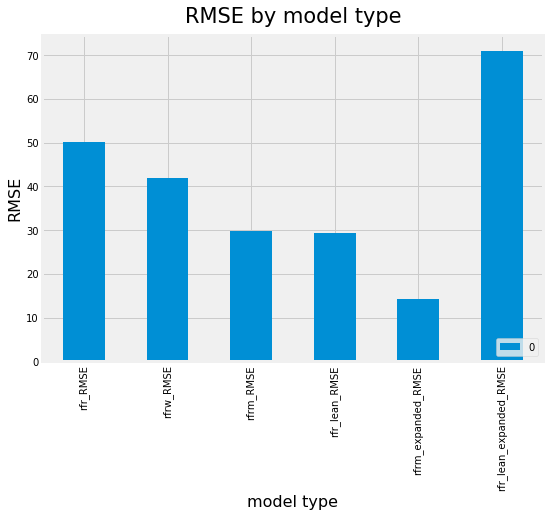

In [317]:
ax = performance_RMSE.plot(kind='bar', figsize=(8,6));
ax.set_title('RMSE by model type', fontsize=21, y=1.02); 
ax.legend(loc=4); 
ax.set_ylabel('RMSE', fontsize=16);
ax.set_xlabel('model type', fontsize=16);

In [318]:
performance_score = pd.DataFrame(list(zip([rfr_score,rfrw_score,rfrm_score,rfr_lean_score,
     rfrm_expanded_score,rfr_lean_expanded_score],['rfr_score','rfrw_score','rfrm_score','rfr_lean_score',
     'rfrm_expanded_score','rfr_lean_expanded_score']))).set_index(1)

(0.95, 1.025)

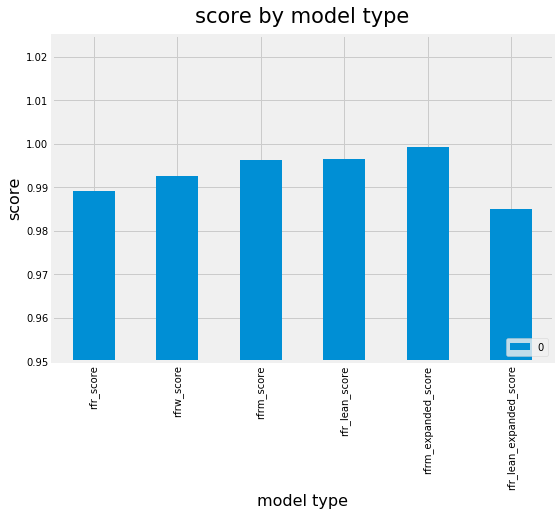

In [322]:
ax = performance_score.plot(kind='bar', figsize=(8,6));
ax.set_title('score by model type', fontsize=21, y=1.02); 
ax.legend(loc=4); 
ax.set_ylabel('score', fontsize=16);
ax.set_xlabel('model type', fontsize=16);
ax.set_ylim(top=1.025)
ax.set_ylim(bottom=0.95)

random forest regression on a 30-day base rolling, expanded dataset, has the best performance and will thus be the choice for future projection.

## STEP FINAL. Out of the sample prediction

In [635]:
data_2019 = treasury_data(2019)

In [636]:
treasury = data_2019.convert_objects(convert_numeric=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [637]:
treasury.head()

date  one_mon  three_mon  six_mon  one_yr  two_yr  three_yr  \
0  2019-01-02T00:00:00     2.40       2.42     2.51    2.60    2.50      2.47   
1  2019-01-03T00:00:00     2.42       2.41     2.47    2.50    2.39      2.35   
2  2019-01-04T00:00:00     2.40       2.42     2.51    2.57    2.50      2.47   
3  2019-01-07T00:00:00     2.42       2.45     2.54    2.58    2.53      2.51   
4  2019-01-08T00:00:00     2.40       2.46     2.54    2.60    2.58      2.57   

   five_yr  seven_yr  ten_yr  twenty_yr  thirty_yr  
0     2.49      2.56    2.66       2.83       2.97  
1     2.37      2.44    2.56       2.75       2.92  
2     2.49      2.56    2.67       2.83       2.98  
3     2.53      2.60    2.70       2.86       2.99  
4     2.58      2.63    2.73       2.88       3.00

In [638]:
treasury['market_day'] = pd.to_datetime(treasury.date)

In [639]:
treasury = treasury.set_index('market_day')
treasury = treasury.drop('date',axis=1)

treasury['1yr1mon'] = treasury.one_yr - treasury.one_mon
treasury['1yr3mon'] = treasury.one_yr - treasury.three_mon
treasury['1yr6mon'] = treasury.one_yr - treasury.six_mon

treasury['2yr1mon'] = treasury.two_yr - treasury.one_mon
treasury['2yr3mon'] = treasury.two_yr - treasury.three_mon
treasury['2yr6mon'] = treasury.two_yr - treasury.six_mon


treasury['3yr1mon'] = treasury.three_yr - treasury.one_mon
treasury['3yr3mon'] = treasury.three_yr - treasury.three_mon
treasury['3yr6mon'] = treasury.three_yr - treasury.six_mon

treasury['5yr1mon'] = treasury.five_yr - treasury.one_mon
treasury['5yr3mon'] = treasury.five_yr - treasury.three_mon
treasury['5yr6mon'] = treasury.five_yr - treasury.six_mon

treasury['7yr1mon'] = treasury.seven_yr - treasury.one_mon
treasury['7yr3mon'] = treasury.seven_yr - treasury.three_mon
treasury['7yr6mon'] = treasury.seven_yr - treasury.six_mon

treasury['10yr1mon'] = treasury.ten_yr - treasury.one_mon
treasury['10yr3mon'] = treasury.ten_yr - treasury.three_mon
treasury['10yr6mon'] = treasury.ten_yr - treasury.six_mon


treasury['20yr1mon'] = treasury.twenty_yr - treasury.one_mon
treasury['20yr3mon'] = treasury.twenty_yr - treasury.three_mon
treasury['20yr6mon'] = treasury.twenty_yr - treasury.six_mon

treasury['30yr1mon'] = treasury.thirty_yr - treasury.one_mon
treasury['30yr3mon'] = treasury.thirty_yr - treasury.three_mon
treasury['30yr6mon'] = treasury.thirty_yr - treasury.six_mon

In [640]:
treasury.head()

one_mon  three_mon  six_mon  one_yr  two_yr  three_yr  five_yr  \
market_day                                                                   
2019-01-02     2.40       2.42     2.51    2.60    2.50      2.47     2.49   
2019-01-03     2.42       2.41     2.47    2.50    2.39      2.35     2.37   
2019-01-04     2.40       2.42     2.51    2.57    2.50      2.47     2.49   
2019-01-07     2.42       2.45     2.54    2.58    2.53      2.51     2.53   
2019-01-08     2.40       2.46     2.54    2.60    2.58      2.57     2.58   

            seven_yr  ten_yr  twenty_yr    ...     7yr6mon  10yr1mon  \
market_day                                 ...                         
2019-01-02      2.56    2.66       2.83    ...        0.05      0.26   
2019-01-03      2.44    2.56       2.75    ...       -0.03      0.14   
2019-01-04      2.56    2.67       2.83    ...        0.05      0.27   
2019-01-07      2.60    2.70       2.86    ...        0.06      0.28   
2019-01-08      2.63    2.73       2.88    ...        0.09      0.33   

            10yr3mon  10yr6mon  20yr1mon  20yr3mon  20yr6mon  30yr1mon  \
market_day                                                               
2019-01-02      0.24      0.15      0.43      0.41      0.32      0.57   
2019-01-03      0.15      0.09      0.33      0.34      0.28      0.50   
2019-01-04      0.25      0.16      0.43      0.41      0.32      0.58   
2019-01-07      0.25      0.16      0.44      0.41      0.32      0.57   
2019-01-08      0.27      0.19      0.48      0.42      0.34      0.60   

            30yr3mon  30yr6mon  
market_day                      
2019-01-02      0.55      0.46  
2019-01-03      0.51      0.45  
2019-01-04      0.56      0.47  
2019-01-07      0.54      0.45  
2019-01-08      0.54      0.46  

[5 rows x 35 columns]

In [641]:
sp_cols = ['market_day','sp_open','sp_high','sp_low','sp_close','sp_adj_close','sp_volume']
sp = pd.read_csv('./data/SP2008.csv', header=0, names=sp_cols)

sp = sp.set_index('market_day')
sp['sp_previous'] = sp['sp_close'].shift(1)
sp['sp_change'] = sp['sp_close']-sp['sp_previous']
sp['sp'] = sp['sp_close'].shift(-1)

sp.tail()

sp_open      sp_high       sp_low     sp_close  sp_adj_close  \
market_day                                                                     
2019-01-25  2657.439941  2672.379883  2657.330078  2664.760010   2664.760010   
2019-01-28  2644.969971  2644.969971  2624.060059  2643.850098   2643.850098   
2019-01-29  2644.889893  2650.929932  2631.050049  2640.000000   2640.000000   
2019-01-30  2653.620117  2690.439941  2648.340088  2681.050049   2681.050049   
2019-01-31  2685.489990  2708.949951  2678.649902  2704.100098   2704.100098   

             sp_volume  sp_previous  sp_change           sp  
market_day                                                   
2019-01-25  3814080000  2642.330078  22.429932  2643.850098  
2019-01-28  3612810000  2664.760010 -20.909912  2640.000000  
2019-01-29  3504200000  2643.850098  -3.850098  2681.050049  
2019-01-30  3857810000  2640.000000  41.050049  2704.100098  
2019-01-31  4917650000  2681.050049  23.050049          NaN

In [642]:
vix_cols = ['day','vix_open','vix_high','vix_low','vix_close']
vix = pd.read_csv('./data/vix.csv', header=1, names=vix_cols)

vix['market_day'] = pd.to_datetime(vix.day)

vix = vix.set_index('market_day')
vix.head()

day  vix_open  vix_high  vix_low  vix_close
market_day                                                  
2004-01-02  1/2/2004     17.96     18.68    17.54      18.22
2004-01-05  1/5/2004     18.45     18.49    17.44      17.49
2004-01-06  1/6/2004     17.66     17.67    16.19      16.73
2004-01-07  1/7/2004     16.72     16.75    15.50      15.50
2004-01-08  1/8/2004     15.42     15.68    15.32      15.61

In [643]:
mega = pd.merge(treasury,sp,left_index=True,right_index=True)

In [644]:
mega.shape

(21, 44)

In [645]:
mega = pd.merge(mega,vix,left_index = True, right_index=True)

In [646]:
mega.shape

(21, 49)

In [647]:
data = mega[['1yr1mon','1yr3mon', '1yr6mon', '2yr1mon', '2yr3mon', '2yr6mon', 
            '3yr1mon','3yr3mon', '3yr6mon', '5yr1mon', '5yr3mon', '5yr6mon', 
            '7yr1mon','7yr3mon', '7yr6mon', '10yr1mon', '10yr3mon', '10yr6mon', 
            '20yr1mon','20yr3mon', '20yr6mon', '30yr1mon', '30yr3mon', '30yr6mon', 
            'sp','vix_close']]

In [676]:
data.tail()

1yr1mon  1yr3mon  1yr6mon  2yr1mon  2yr3mon  2yr6mon  3yr1mon  \
market_day                                                                  
2019-01-27     0.24     0.21     0.09     0.24     0.21     0.09     0.22   
2019-01-28     0.21     0.18     0.09     0.21     0.18     0.09     0.19   
2019-01-29     0.21     0.18     0.09     0.17     0.14     0.05     0.15   
2019-01-30     0.17     0.15     0.07     0.12     0.10     0.02     0.09   
2019-01-31     0.13     0.14     0.09     0.03     0.04    -0.01     0.01   

            3yr3mon  3yr6mon  5yr1mon    ...      10yr3mon  10yr6mon  \
market_day                               ...                           
2019-01-27     0.19     0.07     0.23    ...          0.37      0.25   
2019-01-28     0.16     0.07     0.19    ...          0.33      0.24   
2019-01-29     0.12     0.03     0.16    ...          0.30      0.21   
2019-01-30     0.07    -0.01     0.09    ...          0.28      0.20   
2019-01-31     0.02    -0.03     0.01    ...          0.22      0.17   

            20yr1mon  20yr3mon  20yr6mon  30yr1mon  30yr3mon  30yr6mon  \
market_day                                                               
2019-01-27      0.56      0.53      0.41      0.70      0.67      0.55   
2019-01-28      0.53      0.50      0.41      0.67      0.64      0.55   
2019-01-29      0.51      0.48      0.39      0.65      0.62      0.53   
2019-01-30      0.50      0.48      0.40      0.66      0.64      0.56   
2019-01-31      0.41      0.42      0.37      0.57      0.58      0.53   

                     sp  vix_close  
market_day                          
2019-01-27  2643.850098      17.42  
2019-01-28  2640.000000      18.87  
2019-01-29  2681.050049      19.13  
2019-01-30  2704.100098      17.66  
2019-01-31          NaN      16.57  

[5 rows x 26 columns]

In [684]:
data = data.resample('D').pad()

In [685]:
data.shape

(30, 26)

In [703]:
feature_cols = ['1yr1mon','1yr3mon', '1yr6mon', '2yr1mon', '2yr3mon', '2yr6mon', 
            '3yr1mon','3yr3mon', '3yr6mon', '5yr1mon', '5yr3mon', '5yr6mon', 
            '7yr1mon','7yr3mon', '7yr6mon', '10yr1mon', '10yr3mon', '10yr6mon', 
            '20yr1mon','20yr3mon', '20yr6mon', '30yr1mon', '30yr3mon', '30yr6mon','vix_close']

In [706]:
Xm = data[feature_cols]
ym = data['sp']

ym_pred = rfrm_expanded.predict(Xm)

In [707]:
ym_pred

array([2571.69991697, 2566.10575193, 2571.69991697, 2571.69991697,
       2571.69991697, 2571.69991697, 2571.69991697, 2571.69991697,
       2571.69991697, 2571.69991697, 2571.69991697, 2571.69991697,
       2571.69991697, 2571.69991697, 2571.69991697, 2571.69991697,
       2571.69991697, 2571.69991697, 2571.69991697, 2571.69991697,
       2571.69991697, 2571.69991697, 2571.69991697, 2571.69991697,
       2571.69991697, 2571.69991697, 2571.69991697, 2571.69991697,
       2571.69991697, 2571.69991697])

In [708]:
ym = np.array(ym)
ym = ym[~np.isnan(ym)]

In [709]:
ym

array([2447.889893, 2531.939941, 2549.689941, 2549.689941, 2549.689941,
       2574.409912, 2584.959961, 2596.639893, 2596.26001 , 2582.610107,
       2582.610107, 2582.610107, 2610.300049, 2616.100098, 2635.959961,
       2670.709961, 2632.899902, 2632.899902, 2632.899902, 2632.899902,
       2638.699951, 2642.330078, 2664.76001 , 2643.850098, 2643.850098,
       2643.850098, 2640.      , 2681.050049, 2704.100098])

In [710]:
np.sqrt(metrics.mean_squared_error(np.array(ym),ym_pred[1:30]))

64.0734989978008

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


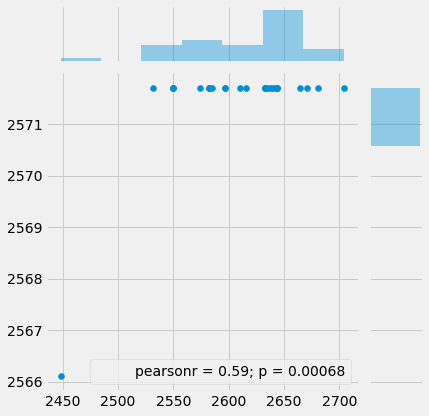

In [711]:
sns.jointplot(np.array(ym),ym_pred[1:30])